**PREPROCESSING AND SENTIMENT ANALYSIS USING PRE-TRAINED MODEL**

In [2]:
!pip install pyspark emoji textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 34.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=2b99a2039fa91c5640cff2d0119425231a4d7c151e57ce1ab4f94cae288b6001
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, trim, udf
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover
from textblob import TextBlob
import emoji

spark = SparkSession.builder.appName("Data Preprocessing").getOrCreate()

data_path = "Sentiment.csv"  # Change to the correct path
df = spark.read.csv(data_path, header=True, inferSchema=True)

# Remove retweets
clean_df = df.filter(~col("text").startswith("RT"))
cleaned_df =clean_df.filter(~col("text").startswith('"RT'))

# Drop duplicates based on tweet_id
cleaned_df = cleaned_df.dropDuplicates(["tweet_id"])

# Drop unwanted columns
columns_to_drop = ["candidate_gold", "sentiment_gold", "subject_matter_gold","relevant_yn_gold"]
cleaned_df = cleaned_df.drop(*columns_to_drop)

# Keep only relevant tweets
cleaned_df = cleaned_df.filter(col("relevant_yn") == "yes")

#Tokenize text and remove stop words
tokenizer = Tokenizer(inputCol="text", outputCol="words")
tokenized_df = tokenizer.transform(cleaned_df)

stopwords_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")
cleaned_tokenized_df = stopwords_remover.transform(tokenized_df)

#Replace emojis with text
def replace_emojis(text):
    return emoji.demojize(text, delimiters=(" ", " "))

emoji_udf = udf(replace_emojis, StringType())
cleaned_df = cleaned_tokenized_df.withColumn("text_no_emoji", emoji_udf(col("text")))

#Remove URLs
def remove_urls(text):
    words = text.split()
    words = [word for word in words if not word.startswith("http")]
    return " ".join(words)

remove_urls_udf = udf(remove_urls, StringType())
cleaned_df = cleaned_df.withColumn("text_no_urls", remove_urls_udf(col("text_no_emoji")))

#Remove special characters
def remove_special_characters(text):
    return "".join([char if char.isalpha() or char.isspace() else " " for char in text])

remove_special_udf = udf(remove_special_characters, StringType())
cleaned_df = cleaned_df.withColumn("text_clean", remove_special_udf(col("text_no_urls")))

#Sentiment analysis
def get_sentiment(text_clean):
    analysis = TextBlob(text_clean)
    if analysis.sentiment.polarity > 0:
        return "Positive"
    elif analysis.sentiment.polarity < 0:
        return "Negative"
    else:
        return "Neutral"

sentiment_udf = udf(get_sentiment, StringType())
cleaned_df = cleaned_df.withColumn("sentiment_label", sentiment_udf(col("text_clean")))

# Display cleaned data
cleaned_df.show(10, truncate=False)


+-----+----------------------+--------------------+-----------+----------------------+---------+--------------------+------------------------------------+-------------------------+---------------+-------------+-------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------+---------------------------------------------------------------------+-----------------------------+-------------------------+----------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------------------------------------

**LOGISTIC REGRESSION**

Accuracy of the sentiment model: 0.62


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


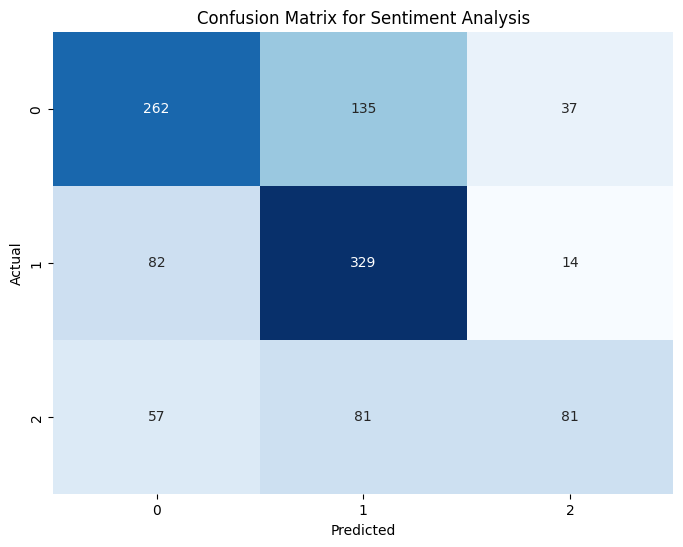

+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|text_clean                                                                                                                                 |sentiment_label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|Cruz  New Sheriff in town  Nice summary  He cherishes freedom   your freedom   GOPDebates                                                  |Positive       |0.0       |
|Santorum said he wants to make America the    manufacturing country  Manufacturing is   th century thinking  We need high tech   GOPDebates|Positive       |0.0       |
|I ve been using the wrong hashtag   GOPDebates  GOPDebate                                                                                  |Negative      

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

label_indexer = StringIndexer(inputCol="sentiment_label", outputCol="label")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

logistic_regression = LogisticRegression(featuresCol="features", labelCol="label")
pipeline = Pipeline(stages=[label_indexer, vectorizer, logistic_regression])

# Train the Model
train_df, test_df = cleaned_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

# Make Predictions
predictions = model.transform(test_df)

# Calculate Accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of the sentiment model: {accuracy:.2f}")

#Confusion Matrix
predictions_and_labels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictions_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

# Compare Actual vs. Predicted
predictions.select("text_clean", "sentiment_label", "prediction").show(10, truncate=False)

**LINEAR REGRESSION**

Root Mean Squared Error (RMSE): 0.7331581773635055
R² (Explained Variance): 0.07966124788395001


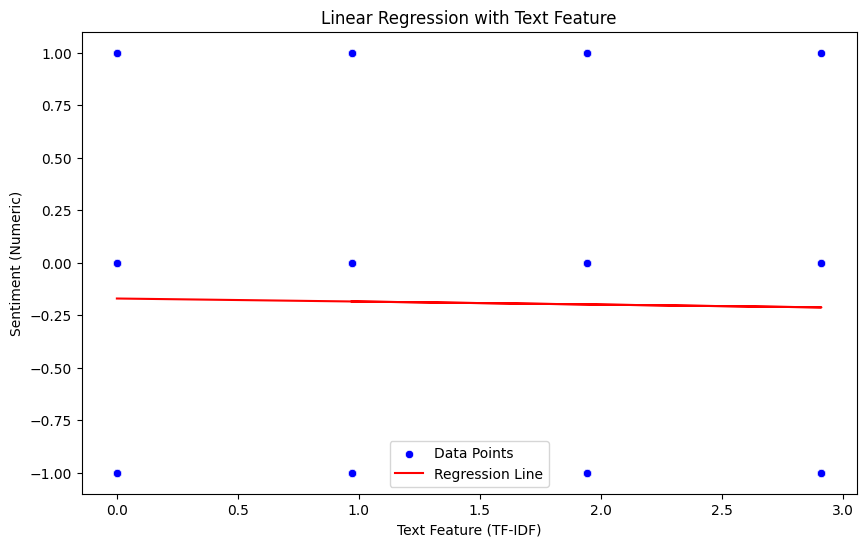

+-----+--------------------+--------------------+-----------+----------------------+---------+--------------------+--------------------+-------------------------+---------------+-------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+--------------------+--------------------+--------------------+
|   id|           candidate|candidate_confidence|relevant_yn|relevant_yn_confidence|sentiment|sentiment_confidence|      subject_matter|subject_matter_confidence|           name|retweet_count|                text|         tweet_coord|       tweet_created|            tweet_id|      tweet_location|       user_timezone|               words|      filtered_words|       text_no_emoji|        text_no_urls|          text_clean|sentiment_label|sentiment_numeric|         word_tokens| 

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, countDistinct
from pyspark.ml.feature import Tokenizer, HashingTF, IDF
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


if cleaned_df.count() == 0:
    raise ValueError("The DataFrame 'cleaned_df' is empty. Please check data preparation steps.")

# 'sentiment' to numeric
cleaned_df = cleaned_df.withColumn("sentiment_numeric",
                                   when(col("sentiment") == "Positive", 1)
                                   .when(col("sentiment") == "Neutral", 0)
                                   .when(col("sentiment") == "Negative", -1)
                                   .otherwise(None))

#  Tokenize 'text_clean' into a new column
tokenizer = Tokenizer(inputCol="text_clean", outputCol="word_tokens")  # Use a unique name
df_tokenized = tokenizer.transform(cleaned_df)

if df_tokenized.count() == 0:
    raise ValueError("Tokenized DataFrame is empty. Check the 'text_clean' column for valid content.")

hashing_tf = HashingTF(inputCol="word_tokens", outputCol="raw_features", numFeatures=100)
df_hashed = hashing_tf.transform(df_tokenized)

if df_hashed.count() == 0:
    raise ValueError("Hashed DataFrame is empty. Check 'word_tokens' content.")

# create feature vectors
idf = IDF(inputCol="raw_features", outputCol="features")
idf_model = idf.fit(df_hashed)  # This line could cause issues if `df_hashed` is empty
df_vectorized = idf_model.transform(df_hashed)

df_prepared = df_vectorized.select("features", "sentiment_numeric")

lr = LinearRegression(featuresCol="features", labelCol="sentiment_numeric")
lr_model = lr.fit(df_prepared)

predictions = lr_model.transform(df_prepared)

evaluator_rmse = RegressionEvaluator(labelCol='sentiment_numeric', predictionCol='prediction', metricName='rmse')
evaluator_r2 = RegressionEvaluator(labelCol='sentiment_numeric', predictionCol='prediction', metricName='r2')

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

print("Root Mean Squared Error (RMSE):", rmse)
print("R² (Explained Variance):", r2)

df_pandas = predictions.select("features", "sentiment_numeric", "prediction").toPandas()

feature_values = [v[0] for v in df_pandas["features"]]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=feature_values, y=df_pandas["sentiment_numeric"], color="blue", label="Data Points")

y_pred = [v * lr_model.coefficients[0] + lr_model.intercept for v in feature_values]
plt.plot(feature_values, y_pred, color="red", label="Regression Line")

plt.xlabel("Text Feature (TF-IDF)")
plt.ylabel("Sentiment (Numeric)")
plt.title("Linear Regression with Text Feature")

plt.legend()

plt.show()
df_vectorized.show()



**K-MEANS CLUSTERING AND K NEAREST NEIGHBOURS**

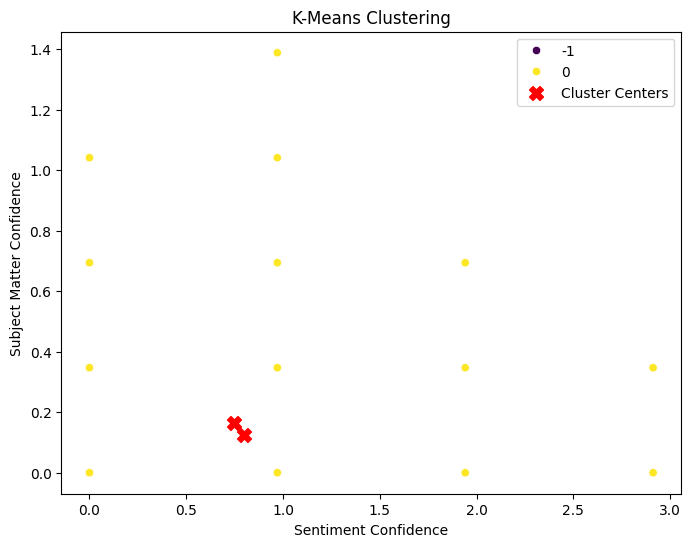

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.sql import SparkSession
import numpy as np

train_df, test_df = df_vectorized.randomSplit([0.8, 0.2], seed=42)
train_df = train_df.limit(1500)

kmeans = KMeans(k=2, featuresCol="features")
model = kmeans.fit(train_df)

#cluster centers
centers = model.clusterCenters()
centers_np = np.array(centers)  # centers to a NumPy array

plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_pandas["features"].apply(lambda x: x[0]),
                y=df_pandas["features"].apply(lambda x: x[1]),
                hue=df_pandas["prediction"].astype(int),  # Convert to int for plotting
                palette="viridis")
plt.scatter(centers_np[:, 0], centers_np[:, 1], c='red', s=100, marker='X', label='Cluster Centers')
plt.title("K-Means Clustering")
plt.xlabel("Sentiment Confidence")
plt.ylabel("Subject Matter Confidence")
plt.legend()
plt.show()


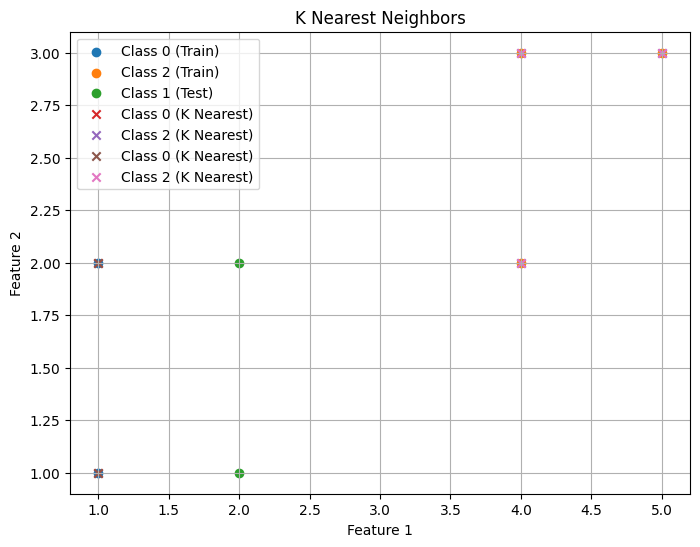

In [35]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.sql.functions import col, collect_list
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

assembler = VectorAssembler(inputCols=["features"], outputCol="feature_vector")
df_assembled = assembler.transform(df_vectorized)

train_df, test_df = df_assembled.randomSplit([0.8, 0.2], seed=42)

test_df = test_df.withColumn("distance", F.udf(lambda x, y: float(np.linalg.norm(x - y)), DoubleType())
                             (F.col("feature_vector"), F.array([F.lit(v) for v in test_df.select("feature_vector").first()[0]])))


k = 5
k_nearest_df = test_df.orderBy("distance").limit(k)

if 'predicted_label' in k_nearest_df.columns:
    predicted_labels_df = k_nearest_df.select("feature_vector", "predicted_label")

else:
    print("'predicted_label' column does not exist in the DataFrame 'k_nearest_df'. Check the code for computing predicted labels.")


In [6]:
train_df.show()

+-----+--------------------+--------------------+-----------+----------------------+---------+--------------------+--------------------+-------------------------+---------------+-------------+--------------------+-----------+--------------------+------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+-----------------+--------------------+--------------------+--------------------+
|   id|           candidate|candidate_confidence|relevant_yn|relevant_yn_confidence|sentiment|sentiment_confidence|      subject_matter|subject_matter_confidence|           name|retweet_count|                text|tweet_coord|       tweet_created|          tweet_id|      tweet_location|       user_timezone|               words|      filtered_words|       text_no_emoji|        text_no_urls|          text_clean|sentiment_label|sentiment_numeric|         word_tokens|        raw_features|  

**BATCH GRADIENT DESCENT AND SCHOTASTIC GRADIENT DESCENT**

Accuracy of the sentiment model: 0.73


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


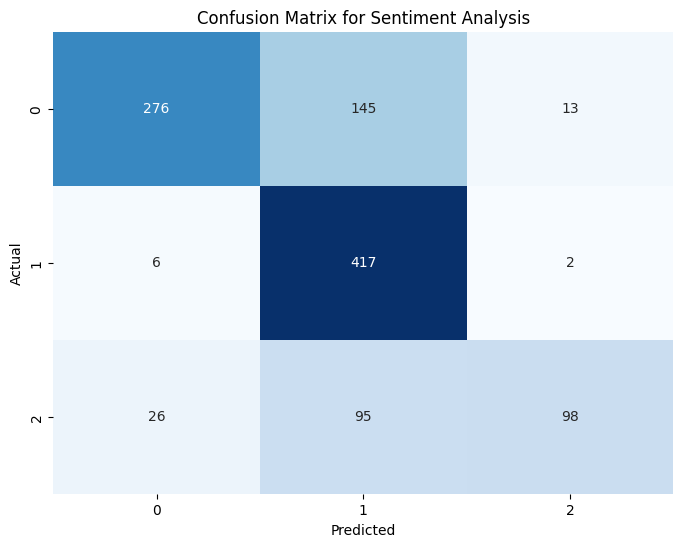

+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|text_clean                                                                                                                                 |sentiment_label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|Cruz  New Sheriff in town  Nice summary  He cherishes freedom   your freedom   GOPDebates                                                  |Positive       |0.0       |
|Santorum said he wants to make America the    manufacturing country  Manufacturing is   th century thinking  We need high tech   GOPDebates|Positive       |0.0       |
|I ve been using the wrong hashtag   GOPDebates  GOPDebate                                                                                  |Negative      

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("BGD").getOrCreate()

label_indexer = StringIndexer(inputCol="sentiment_label", outputCol="label")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

logistic_regression = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.02, elasticNetParam=0.6,
                                         fitIntercept=True, standardization=True) 

pipeline = Pipeline(stages=[label_indexer, vectorizer, logistic_regression])

train_df, test_df = cleaned_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of the sentiment model: {accuracy:.2f}")

predictions_and_labels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictions_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

predictions.select("text_clean", "sentiment_label", "prediction").show(10, truncate=False)

Accuracy of the sentiment model: 0.75


/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


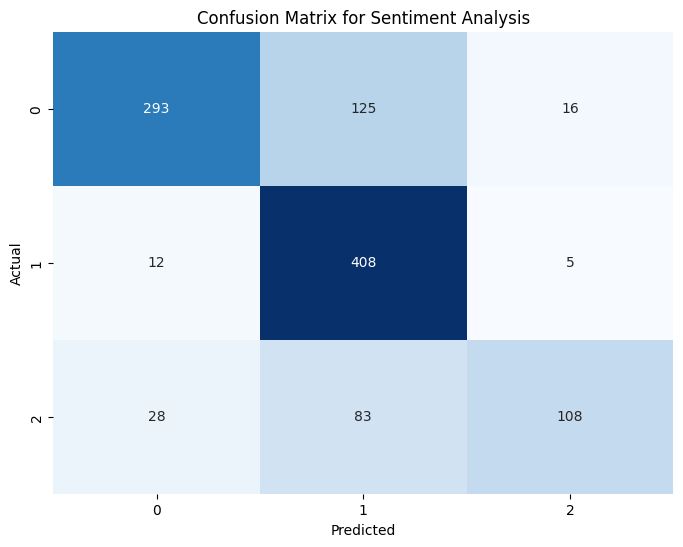

+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|text_clean                                                                                                                                 |sentiment_label|prediction|
+-------------------------------------------------------------------------------------------------------------------------------------------+---------------+----------+
|Cruz  New Sheriff in town  Nice summary  He cherishes freedom   your freedom   GOPDebates                                                  |Positive       |0.0       |
|Santorum said he wants to make America the    manufacturing country  Manufacturing is   th century thinking  We need high tech   GOPDebates|Positive       |0.0       |
|I ve been using the wrong hashtag   GOPDebates  GOPDebate                                                                                  |Negative      

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import CountVectorizer, StringIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("SGD").getOrCreate()

label_indexer = StringIndexer(inputCol="sentiment_label", outputCol="label")
vectorizer = CountVectorizer(inputCol="filtered_words", outputCol="features")

logistic_regression = LogisticRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.01, elasticNetParam=0.8,
                                         fitIntercept=True, standardization=True) 

pipeline = Pipeline(stages=[label_indexer, vectorizer, logistic_regression])

train_df, test_df = cleaned_df.randomSplit([0.8, 0.2], seed=42)
model = pipeline.fit(train_df)

predictions = model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)

print(f"Accuracy of the sentiment model: {accuracy:.2f}")

predictions_and_labels = predictions.select("prediction", "label").rdd
metrics = MulticlassMetrics(predictions_and_labels)
confusion_matrix = metrics.confusionMatrix().toArray()

plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Sentiment Analysis")
plt.show()

predictions.select("text_clean", "sentiment_label", "prediction").show(10, truncate=False)